# Setting up our Notebook

In [10]:
# Things to import

# Standard data, plotting, time, and mathematical tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as time
import seaborn as sns

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

# Grid Search
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from IPython.display import Image

# Importing the data

In [2]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv']

# Multi-Layer Perceptron

## Mathematical Description

### Perceptron

The perceptron can be thought of as a computational structure with weights $\bf{w}$, bias $b$, and activation function $g(z)$. It takes as input $\bf{x}$ and computes $g({\bf{w}}^T{\bf{x}}+b)$.

The activation function $g(z)$ can vary and allows for the structure to learn non-linearities. 

Graphically, this can be represented as:

<img src="Graphics/Perceptron.png" width="600" height="600" />

They can then be stacked together into a single layer and then as several layers, creating a Deep Neural Network.

<img src="Graphics/MLP.png" width="600" height="600" />

### Mathematics of the MLP

Let the data be collected into a matrix $X$, where $X$ is an $(n_x, m)$ matrix, of $n_x$ data instances of $m$ features.

The target values associated with each ${\bf{x}} \in X$ are collected into $Y$.

Define $A^{[l]}$ as the output of the $l^{th}$ layer over all data instances. So, $A^{[0]}=X$. Let $W^{[l]}$ be the weights of the $l^{th}$ layer and $b^{[l]}$ the vector of biases of the same layer and $(W,b)$ be collection of all weights and biases for the MLP. Let $L$ be the total number of layers in this MLP.

Define:

$$f^{[l]}_{(W^{[l]},b^{[l]})}=g(W^{[l]}f^{[l-1]}_{(W^{[l-1]},b^{[l-1]})}+b^{[l]})$$

Then, the whole structure can be represented as: 

$${\hat{Y}}=F_{(W,b)}=f^{[L]}_{(W^{[L]},b^{[L]})} \circ\ ... \circ\ f^{[1]}_{(W^{[1]},b^{[1]})}(X)$$

We then seek to minimize the Cost Function, $J(W,b)={\dfrac{1}{m}}\sum_{i=1}^{m}{\mathcal{L}}_{(W,b)}(Y^{(i)},\hat{Y} {^{(i)}})$. We do this through Gradient Descent. 

Given a batch size on the $k^{th}$ feed-forward iteration of $s^k$, we update our parameters (weights and biases) with:

$$(W,b)^{k+1}=(W,b)^k-\dfrac{\alpha_k}{s^k} (\sum_{i \in \{1,...,s^k\}} \nabla {\mathcal{L}}_{(W,b)^k}(Y^{(i)},\hat{Y} {^{(i)}}))$$

## Training

### Getting the train/test data

In [3]:
# Defining a function to create PCA matrices

def PCA_creation_train_val_test(no_components, X_train, X_val, X_test):
    
    # Scaling the data with our X_train matrix
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    
    # Fitting the PCA to our X_train matrix
    pca=PCA(n_components=no_components)
    X_train=pca.fit_transform(X_train)

    # Scaling the X_val and X_test 
    X_val=scaler.transform(X_val)
    X_test=scaler.transform(X_test)

    # Transforming the X_val and X_test
    X_val=pca.transform(X_val)
    X_test=pca.transform(X_test)
    
    return X_train, X_val, X_test

In [6]:
# Train and test splitting and scaling

X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Label']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)


# Removing the testing data
X_test=X[-4380:] # Getting the last 6 months as the testing data
print('Confirming we have all the columns we want:','\n', X_test.columns)
y_test=y[-4380:].values

X=X[:-4380] # Getting everything but the first 6 months as the training data
y=y[:-4380]

num_classes=2 # Used for one-hot encoding, but we won't be doing that with 2 classes

# Split into training and validation for our neural net
X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.2, random_state=100, shuffle=True)
y_train=np.array(y_train)
y_val=np.array(y_val)

X_train, X_val, X_test=PCA_creation_train_val_test(20, X_train, X_val, X_test)

Confirming we have all the columns we want: 
 Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)


### Grid Search for Optimizer and parameters

In [7]:
# Function to create the model for Keras wrapper to scikit learn

# We will optimize the number of layers, the activation function, the neurons per layer, 
# and the optimizer

def create_mlp_model(activ_function='relu', neurons=50, dropout_rate=0.1, num_layers=2, 
                     optimizer='adam', learning_rate=1e-3):
    
    # Create the model and run through the number of layers
    model = keras.Sequential()
        
    if num_layers==2:
        # First layer
        model.add(keras.layers.Dense(neurons, activation=activ_function, input_shape=(X_train.shape[1],)))
        model.add(keras.layers.Dropout(dropout_rate))
        # Second layer
        model.add(keras.layers.Dense(neurons, activation=activ_function))
        model.add(keras.layers.Dropout(dropout_rate))
        
    if num_layers==3:
        # First layer
        model.add(keras.layers.Dense(neurons, activation=activ_function, input_shape=(X_train.shape[1],)))
        model.add(keras.layers.Dropout(dropout_rate))
        # Second layer
        model.add(keras.layers.Dense(neurons, activation=activ_function))
        model.add(keras.layers.Dropout(dropout_rate))
        # Third layer
        model.add(keras.layers.Dense(neurons, activation=activ_function))
        model.add(keras.layers.Dropout(dropout_rate))
        
    if num_layers==4:
        # First layer
        model.add(keras.layers.Dense(neurons, activation=activ_function, input_shape=(X_train.shape[1],)))
        model.add(keras.layers.Dropout(dropout_rate))
        # Second layer
        model.add(keras.layers.Dense(neurons, activation=activ_function))
        model.add(keras.layers.Dropout(dropout_rate))
        # Third layer
        model.add(keras.layers.Dense(neurons, activation=activ_function))
        model.add(keras.layers.Dropout(dropout_rate))
        # Fourth layer
        model.add(keras.layers.Dense(neurons, activation=activ_function))
        model.add(keras.layers.Dropout(dropout_rate))
        
    if num_layers==5:
        # First layer
        model.add(keras.layers.Dense(neurons, activation=activ_function, input_shape=(X_train.shape[1],)))
        model.add(keras.layers.Dropout(dropout_rate))
        # Second layer
        model.add(keras.layers.Dense(neurons, activation=activ_function))
        model.add(keras.layers.Dropout(dropout_rate))
        # Third layer
        model.add(keras.layers.Dense(neurons, activation=activ_function))
        model.add(keras.layers.Dropout(dropout_rate))
        # Fourth layer
        model.add(keras.layers.Dense(neurons, activation=activ_function))
        model.add(keras.layers.Dropout(dropout_rate))
        # Fifth layer
        model.add(keras.layers.Dense(neurons, activation=activ_function))
        model.add(keras.layers.Dropout(dropout_rate))
        
    if num_layers==6:
        # First layer
        model.add(keras.layers.Dense(neurons, activation=activ_function, input_shape=(X_train.shape[1],)))
        model.add(keras.layers.Dropout(dropout_rate))
        # Second layer
        model.add(keras.layers.Dense(neurons, activation=activ_function))
        model.add(keras.layers.Dropout(dropout_rate))
        # Third layer
        model.add(keras.layers.Dense(neurons, activation=activ_function))
        model.add(keras.layers.Dropout(dropout_rate))
        # Fourth layer
        model.add(keras.layers.Dense(neurons, activation=activ_function))
        model.add(keras.layers.Dropout(dropout_rate))
        # Fifth layer
        model.add(keras.layers.Dense(neurons, activation=activ_function))
        model.add(keras.layers.Dropout(dropout_rate))
        # Sixth layer
        model.add(keras.layers.Dense(neurons, activation=activ_function))
        model.add(keras.layers.Dropout(dropout_rate))
        
    # Final layer with softmax for classification
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    
    # Running through the optimizers
    if optimizer=='adam': 
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        
    if optimizer=='RMSprop':
        optimizer = keras.optimizers.RMSProp(learning_rate=learning_rate)
        
    if optimizer=='SGD':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
        
    # Compile model
    model.compile( 
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy'],
        )    
    return model

Note, the grid search section for this script, as well as the CNN and LSTM, take heavy influence from the following Kaggle notebook: MNIST: CNN, grid search, data augmentation

This can be found at:

https://www.kaggle.com/code/cedricb/mnist-cnn-grid-search-data-augmentation/notebook

In [8]:
# Creating and compiling the model with a summary

mlp = create_mlp_model()
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                1050      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,651
Trainable params: 3,651
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Optimize the model with grid search

start=time.time()
# Grid search parameters
n_epochs_cv = 20 # Number of epochs for our grid search
n_cv = 3 # Number of cross validations

# Create model to feed to our parameter grid search
model = KerasClassifier(build_fn=create_mlp_model, verbose=0)

# Define parameters and values for grid search to check in our model
param_grid = {
    # Model parameters
    'activ_function':['relu', 'tanh', 'sigmoid'],
    'neurons':[256, 512, 1024],
    'dropout_rate':[0.5, 0.6],
    'num_layers':[2, 4, 6],
    'optimizer':['adam', 'RMSProp', 'SGD'],
    'learning_rate':[1e-3, 1e-5, 1e-7],
    # The number of epochs for each model
    'epochs': [n_epochs_cv],
}

# Creating the grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=2, cv=n_cv)

# Fitting the grid
grid_result = grid.fit(X_train, y_train)

end=time.time()
print('This grid search took', end-start, 'seconds')

In [ ]:
print(grid_result.best_params_)

### MLP with Optimized Features

In [ ]:
# From the grid search on a single computer

mlp_model=create_mlp_model(activ_function=grid_result.best_params_['activ_function'], 
                                            neurons=grid_result.best_params_['neurons'], 
                                            dropout_rate=grid_result.best_params_['dropout_rate'],
                                            num_layers=grid_result.best_params_['num_layers'],
                                            optimizer=grid_result.best_params_['optimizer'],
                          learning_rate=grid_result.best_params_['learning rate'])

# Fitting the model
history = mlp_model.fit(X_train, y_train, epochs=50, validation_data=(X_val,y_val), verbose=0)

In [17]:
# From our grid search run on the clusters

mlp_model=create_mlp_model(activ_function='relu', 
                                            neurons=512, 
                                            dropout_rate=0.6,
                                            num_layers=2,
                                            optimizer='adam',
                          learning_rate=1e-5)

# Fitting the model
history = mlp_model.fit(X_train, y_train, epochs=30, validation_data=(X_val,y_val), verbose=1)

Epoch 1/30
657/657 [==============================] - 6s 8ms/step - loss: 0.7855 - accuracy: 0.5020 - val_loss: 0.6960 - val_accuracy: 0.5278
Epoch 2/30
657/657 [==============================] - 4s 6ms/step - loss: 0.7698 - accuracy: 0.5136 - val_loss: 0.6923 - val_accuracy: 0.5405
Epoch 3/30
657/657 [==============================] - 4s 7ms/step - loss: 0.7561 - accuracy: 0.5243 - val_loss: 0.6919 - val_accuracy: 0.5390
Epoch 4/30
657/657 [==============================] - 5s 7ms/step - loss: 0.7520 - accuracy: 0.5195 - val_loss: 0.6908 - val_accuracy: 0.5432
Epoch 5/30
657/657 [==============================] - 4s 7ms/step - loss: 0.7488 - accuracy: 0.5243 - val_loss: 0.6897 - val_accuracy: 0.5483
Epoch 6/30
657/657 [==============================] - 5s 7ms/step - loss: 0.7417 - accuracy: 0.5256 - val_loss: 0.6879 - val_accuracy: 0.5518
Epoch 7/30
657/657 [==============================] - 5s 8ms/step - loss: 0.7407 - accuracy: 0.5226 - val_loss: 0.6894 - val_accuracy: 0.5460
Epoch 

### Performance

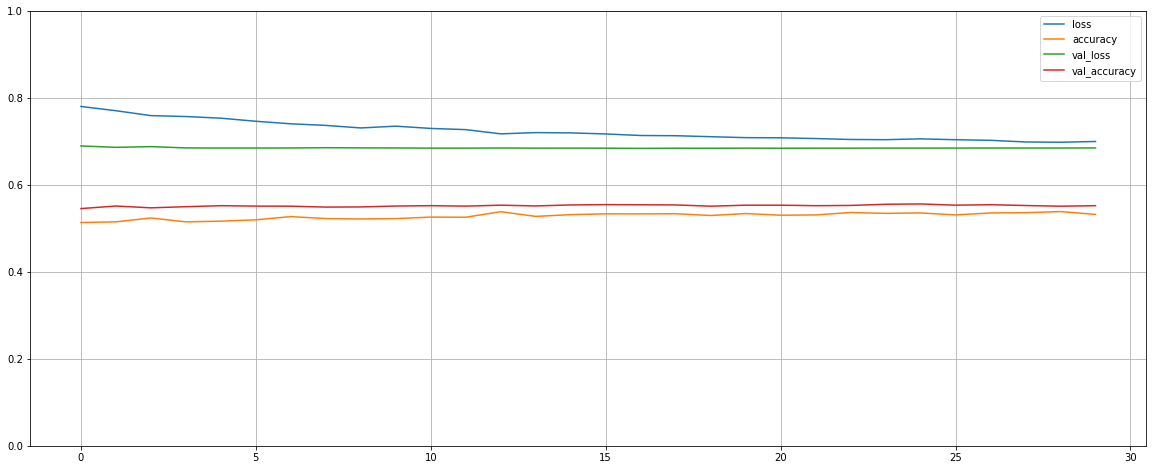

In [8]:
# Training Performance

history.history.keys()
pd.DataFrame(history.history).plot(figsize=(20, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

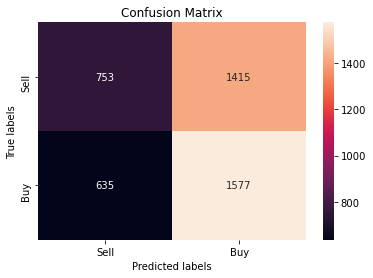

In [18]:
# Confusion Matrix

# # Performance
y_pred=mlp_model.predict(X_test) # Returns a list where every element is an array with the continuous
# value prediction
y_pred=[x[0] for x in y_pred] # Getting all the continuous value predictions from the arrays
for i in range(len(y_pred)): # Transforming the continuous value into binary labels
    if y_pred[i] <= 0.5:
        y_pred[i] = 0
    if y_pred[i] > 0.5:
        y_pred[i] = 1

# Plotting Confusion Matrix
cm=confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Sell', 'Buy']); ax.yaxis.set_ticklabels(['Sell', 'Buy']);

### Saving and Reloading the Model

In [19]:
# Saving the model

mlp_model.save('Models/MLP 4 BTC.h5')

In [ ]:
# # Reloading the model

# mlp_model= keras.models.load_model('Models/MLP 1H BTC.h5')